### Final Project TD-Data Mining
Notebook ini membahas penerapan data mining dalam bidang human resource, terutama dalam memprediksi pegawai apakah dalam kondisi 'Best Performance' atau tidak. <br>
Pembahasan atau kode pada notebook ini berdasarkan kompetisi BRI Data Hackaton pada tahun 2021 untuk topik People Analytics (PA). <br>
Untuk link kompetisi dapat dilihat [disini](https://www.kaggle.com/competitions/bri-data-hackathon-pa/overview) <br>
Untuk open dataset dapat dilihat [disini](https://github.com/IndonesiaAI/BRI-Data-Hackathon) [unofficial] <br>

#### Metrik evaluasi
Untuk metrik evaluasi yang digunakan yaitu accuracy, precision, recall, f1-score, auc score dan confusion matrix

#### Load library
Library di load sekaligus pada cell dibawah, berikut detailnya:
- Pandas dan Numpy untuk memproses data
- Matplotlib dan Seaborn untuk visualisasi data
- Datetime untuk get tahun saat ini 
- GaussianNB, RandomForestClassifier, LGBMClassifier adalah object yang merupakan algoritma dari klasifikasi supervised
- StandardScaler untuk normalisasi data
- Sklearn.metrics untuk evaluasi model

In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 

import datetime

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from random import seed

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split

import warnings

warnings.filterwarnings('ignore')

seed(20)

#### Load dataset
Dataset pada link diatas terdiri dari dataset training dan testing. Namun dataset testing tidak memiliki ground truth, sehingga tidak diperlukan (hanya untuk kebutuhan submission) <br>
Maka untuk menguji akurasi dari model yang dibangun dilakukan dengan melakukan spliiting dataset training dengan komposisi training:testing yaitu 70:30

In [2]:
# Load dataset
train = pd.read_csv('./train.csv')

print(train.shape)

train.head()

(22005, 30)


,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),...,assign_of_otherposition,annual leave,sick_leaves,Best Performance,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,JG05,8.00,PG06,8.00,0.50,RM_type_A,Permanent,Female,1964,Y,...,0,8,0,0,68.85,72.53,0.0,achiev_50%-100%,achiev_< 50%,reached
1,JG04,5.17,PG04,2.00,1.25,RM_type_A,Permanent,Male,1979,Y,...,9,3,0,0,94.81,101.13,3.0,achiev_50%-100%,achiev_50%-100%,reached
2,JG04,1.83,PG03,1.83,1.50,RM_type_A,Permanent,Male,1980,Y,...,0,6,0,0,72.82,71.30,0.0,achiev_100%-150%,achiev_< 50%,not_reached
3,JG04,7.92,PG04,4.00,0.17,RM_type_A,Permanent,Male,1984,Y,...,0,3,0,0,86.89,90.09,2.0,achiev_50%-100%,achiev_50%-100%,not_reached
4,JG04,1.83,PG03,1.83,2.08,RM_type_A,Permanent,Male,1984,Y,...,11,2,1,1,95.17,100.72,2.0,achiev_< 50%,achiev_> 1.5,not_reached


#### Simple Exploratory Data Analyst (EDA)
Untuk mempermudah proses eksplorasi data, dibuat sebuah fungsi yang bernama __describer__ dengan parameter __dataframe__

In [3]:
# Menjelaskan kondisi data (tipe data, null, unique, dll)
def describer(df):
    describer = pd.DataFrame(columns=['columns', 'type', 'unique', 'no_unique', 'null_values'])

    for index, column in enumerate(df.columns):
        describer.loc[index] = [
            column, df[column].dtype, df[column].unique(), df[column].nunique(), df[column].isnull().sum()
        ]
    
    return describer

In [4]:
# Show describer
print('row:', train.shape[0], ' column:', train.shape[1])

describer(train)

row: 22005  column: 30


,columns,type,unique,no_unique,null_values
0,job_level,object,"[JG05, JG04, JG03, JG06]",4,0
1,job_duration_in_current_job_level,float64,"[8.0, 5.17, 1.83, 7.92, 1.75, 2.42, 1.42, 1.5,...",102,0
2,person_level,object,"[PG06, PG04, PG03, PG05, PG01, PG02, PG07, PG08]",8,0
3,job_duration_in_current_person_level,float64,"[8.0, 2.0, 1.83, 4.0, 1.75, 2.42, 1.42, 1.5, 1...",86,0
4,job_duration_in_current_branch,float64,"[0.5, 1.25, 1.5, 0.17, 2.08, 6.25, 1.33, 5.92,...",71,0
5,Employee_type,object,"[RM_type_A, RM_type_C, RM_type_B, nan]",3,12
6,Employee_status,object,"[Permanent, Contract]",2,0
7,gender,object,"[Female, Male]",2,0
8,age,int64,"[1964, 1979, 1980, 1984, 1986, 1987, 1988, 198...",37,0
9,marital_status_maried(Y/N),object,"[Y, N]",2,0


#### Drop data kategorikal
Karena data kategorikal tidak mungkin diisi dengan nilai (imputation) apapun, maka lebih baik di drop. <br>
Berdasarkan informasi pada tabel diatas, fitur __Employee_type__ memiliki nilai null, sehingga hanya diambil data yang tidak null saja (notna).

In [5]:
# Drop data
train = train[train['Employee_type'].notna()] 

train['Employee_type'].unique()

array(['RM_type_A', 'RM_type_C', 'RM_type_B'], dtype=object)

#### Pemilihan nilai
Dengan asumsi bahwa dataset dibuat pada tahun 2023, maka data yang dapat digunakan apabila fitur __age__ yaitu selisih 2021 dikurangi tahun lahir lebih atau sama dengan 17 tahun. <br>
Fitur __age__ akan diset sebagai selisih antara selisih tahun sekarang dengan tahun lahir apabila lebih dari atau sama dengan 17 tahun. <br>
Fitur __age__ akan diset sebagai None (null) apabila selisih tahun sekarang dengan tahun lahir apabila tidak lebih dari atau tidak sama dengan 17 tahun. <br>

In [6]:
# Umur diatas 17 tahun
year = 2021

train['age'] = train['age'].apply(lambda age: year - age if year - age > 16 < 100 else None)

Secara otomatis fitur __age__ bernilai null tidak akan digunakan

In [7]:
# Umur diatas 17 tahun
train = train[train['age'].notna()]
train['age'] = train['age'].astype('int64')

#### Filter GPA
umumnya GPA atau IPK berada dalam rentang 0 hingga 4.0. Cek terlebih dahulu nilai-nilai dari fitur __GPA__ yang ada pada dataset. <br>
Filter __GPA__ pada rentang 0 hingga 4.

In [8]:
# Select GPA
train = train[train['GPA'].between(0, 4)]

train['GPA'].unique()

array([2.32, 3.25, 3.23, 0.  , 3.65, 2.84, 3.14, 3.01, 2.89, 3.  , 2.7 ,
       3.03, 2.92, 3.44, 2.8 , 2.85, 3.21, 2.95, 2.99, 3.1 , 3.41, 3.19,
       3.35, 3.34, 3.02, 3.22, 3.12, 3.27, 3.28, 3.08, 2.93, 2.74, 3.29,
       3.47, 3.06, 2.63, 2.9 , 3.46, 3.43, 3.09, 2.76, 3.17, 2.98, 3.15,
       3.36, 3.62, 3.16, 2.96, 3.68, 3.2 , 3.57, 3.18, 3.05, 3.8 , 2.97,
       3.5 , 3.51, 3.38, 3.54, 3.67, 2.75, 3.04, 3.63, 2.82, 3.37, 3.42,
       3.3 , 3.6 , 3.71, 2.78, 2.86, 3.31, 2.94, 3.53, 3.26, 3.49, 3.45,
       3.13, 3.33, 3.55, 3.07, 3.69, 3.74, 3.4 , 3.48, 2.87, 2.72, 3.81,
       3.11, 3.56, 3.78, 2.18, 2.79, 2.77, 3.73, 3.32, 3.64, 3.7 , 2.91,
       3.52, 3.76, 3.86, 3.24, 3.58, 3.59, 3.85, 2.81, 3.61, 3.93, 2.71,
       3.39, 2.88, 2.83, 3.79, 2.73, 2.66, 3.66, 2.69, 3.77, 2.57, 2.49,
       3.72, 2.08, 3.84, 2.67, 3.75, 2.64, 3.83, 3.95, 2.43, 2.68, 1.75,
       2.  , 2.65, 2.28, 2.05, 1.  , 2.61, 2.5 , 2.6 , 3.88, 3.92, 2.29,
       2.45, 3.82, 2.27, 3.9 , 2.53, 2.59, 2.58, 3.

#### Tahun lulus
Pada dataset dapat terlihat nilai-nilai pada fitur seperti dibawah ini. Terdapat beberapa nilai yang tidak semestinya (diluar range atau string untuk tahun)

In [9]:
# Year graduated
train['year_graduated'].unique()

array(['1987', '2001', '2007', '2006', '2008', '2011', '2010', '2013',
       '2014', '\\N', '1996', '2009', '2005', '2012', '1989', '1992', '0',
       '2000', '1994', '1997', '1995', '2004', '2015', '1993', '1986',
       '1999', '2003', '2016', '2044', '2018', '1991', '2002', '2017',
       '2201', '1998', '1990', '9999', '1984', '2020', '1988', '1983',
       '1985', '201', '2019', '2031', '____', '3016', '-', '2200', '102',
       '2999', '9464'], dtype=object)

Hapus data yang tidak relevan. __year_graduated__ dibatasi dari 1900 hingga 2021

In [10]:
# Year graduated
train = train[~train['year_graduated'].isin(['\\N', '____', '-'])]

train['year_graduated'] = train['year_graduated'].astype('int64')
train = train[train['year_graduated'].between(1900, 2021)]

train['year_graduated'].unique()

array([1987, 2001, 2007, 2006, 2008, 2011, 2010, 2013, 2014, 1996, 2009,
       2005, 2012, 1989, 1992, 2000, 1994, 1997, 1995, 2004, 2015, 1993,
       1986, 1999, 2003, 2016, 2018, 1991, 2002, 2017, 1998, 1990, 1984,
       2020, 1988, 1983, 1985, 2019], dtype=int64)

#### Educational level
Ambil hanya __Educational_level__ yang bukan null

In [11]:
# Education level
train = train[~train['Education_level'].isna()]

train['Education_level'].unique()

array(['level_4', 'level_5', 'level_3', 'level_1', 'level_2', 'level_0'],
      dtype=object)

#### Job duration
Ambil hanya __job_duration_as_permanent_worker__ yang bukan null

In [12]:
train = train[~train['job_duration_as_permanent_worker'].isna()]

#### Average dan Last achievement (%)
untuk fitur __Avg_achievement\_%__ dan __Last_achievement\_\%__ yang bernilai null dilengkapi dengan nilai mean dari fitur-fitur tersebut. <br>
Hal yang sama juga dilakukan untuk fitur __Achievement_above\_100%_during3quartal__

In [13]:
# Imputation achievement yang kosong
train['Avg_achievement_%'] = train['Avg_achievement_%'].fillna(np.mean(train['Avg_achievement_%'])) 
train['Last_achievement_%'] = train['Last_achievement_%'].fillna(np.mean(train['Last_achievement_%'])) 

In [14]:
train['Achievement_above_100%_during3quartal'] = train['Achievement_above_100%_during3quartal'].fillna(np.mean(train['Achievement_above_100%_during3quartal']))

#### Data kategorikal
Untuk data kategorikal terlebih dahulu diseragamkan labelnya. Kemudian tiap fitur akan disesuaikan atau digantikan labelnya dengan bobot
1. __achievement_target_1__ dan __achievement_target_2__ akan mengalami penyesuaian label terlebih dahulu, lalu nilainya digantikan dengan bobot tertentu
2. __achievement_target_3__ apabila reached akan bernilai 1 dan not reached sebagai 0
3. __job_level__ dari JG03 hingga JG06 akan diberikan bobot secara berurutan dari 1 hingga 4
4. __person_level__ dari PG01 hingga PG08 akan diberikan bobot secara berurutan dari 1 hingga 8
5. __Employee_type__ RM_type_A bernilai 1, RM_type_B bernilai 2 dan RM_type_C bernilai 3
6. __Employee_status__ setelah proses pra pemrosesan hanya tersisa __permanent__ (1)
7. __gender__ antara male dan female dianggap setara (1)

In [15]:
train['achievement_target_1'] = train['achievement_target_1'].replace({
    'achiev_< 50%': '< 50%',
    'Pencapaian < 50%': '< 50%',
    'achiev_50%-100%': '50-100%',
    'Pencapaian 50%-100%': '50-100%',
    'achiev_> 1.5': '> 150%',
    'Pencapaian > 1.5': '> 150%',
    'achiev_100%-150%': '100-150%',
    'Pencapaian 100%-150%': '100-150%',
    'achiev_> 1.5': '> 150%',
    'Pencapaian > 1.5': '> 150%',
})

train['achievement_target_2'] = train['achievement_target_1'].replace({
    'achiev_< 50%': '< 50%',
    'Pencapaian < 50%': '< 50%',
    'achiev_50%-100%': '50-100%',
    'Pencapaian 50%-100%': '50-100%',
    'achiev_> 1.5': '> 150%',
    'Pencapaian > 1.5': '> 150%',
    'achiev_100%-150%': '100-150%',
    'Pencapaian 100%-150%': '100-150%',
    'achiev_> 1.5': '> 150%',
    'Pencapaian > 1.5': '> 150%',
})

train['achievement_target_3'] = train['achievement_target_3'].replace({
    'not reached': 'not_reached'
})

train['job_level'] = train['job_level'].replace({
    'JG03': 1, 'JG04': 2, 'JG05': 3, 'JG06': 4
}) 

train['person_level'] = train['person_level'].replace({
    'PG01': 1, 'PG02': 2, 'PG03': 3, 'PG04': 4, 'PG05': 5, 'PG06': 6, 'PG07': 7, 'PG08': 8
}) 

train['Employee_type'] = train['Employee_type'].replace({
    'RM_type_A': 1, 'RM_type_B': 2, 'RM_type_C': 3 
})

train['Employee_status'] = train['Employee_status'].replace({'Permanent': 1})

train['gender'] = train['gender'].replace({
    'Female': 1, 'Male': 1 
})

train['marital_status_maried(Y/N)'] = train['marital_status_maried(Y/N)'].replace({
    'Y': 1, 'N': 0 
})

train['Education_level'] = train['Education_level'].replace({
   'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4, 'level_5': 5, 'level_6': 6 
})

train['achievement_target_1'] = train['achievement_target_1'].replace({
   'Tidak diberikan target':0, '< 50%': 1, '50-100%': 2, '100-150%': 3, '> 150%': 4 
})

train['achievement_target_2'] = train['achievement_target_2'].replace({
   'Tidak diberikan target':0, '< 50%': 1, '50-100%': 2, '100-150%': 3, '> 150%': 4 
})

train['achievement_target_3'] = train['achievement_target_3'].replace({
   'reached':0, 'not_reached': 1
})

Filter data __achievement_target_1__ hanya data yang tidak null

In [16]:
# Drop null
train = train[~train['achievement_target_1'].isna()]

#### Pemisahan fitur dan label kelas
Mengingat __Best Performance__ adalah kelas label dan selain itu adalah prediktornya, pada cell dibawah ini akan memisahkan kedua hal tersebut berdasarkan nama fiturnya (bukan data) <br>
Tujuannya adalah ketika akan memanggil data, cukup dari nama kolomnya saja (menghindari penulisan nama fitur yang terlalu panjang)

In [17]:
# Pemisahan fitur dan label
col_x = [col for col in train.columns if col != 'Best Performance']
col_y = 'Best Performance'

#### Normalisasi data
Normalisasi data digunakan dengan metode standard scaler. Dengan begitu nilai rata-rata dari distribusi data adalah 0 dan standar deviasinya menjadi 1 <br>
Mengurangi keberagaman data akan meningkatkan kualitas model

In [18]:
# Normalisasi data
scaler = StandardScaler()
scaled = scaler.fit_transform(train[col_x])

scaled.shape

(11280, 29)

In [19]:
# Dataframe untuk testing
train_df = pd.DataFrame(columns=col_x, data=scaled)

#### Label kelas
Visualisasi label kelas apakah dalam kondisi seimbang atau tidak. Pada grafik dibawah ini terlihat adanya kelas yang tidak seimbang

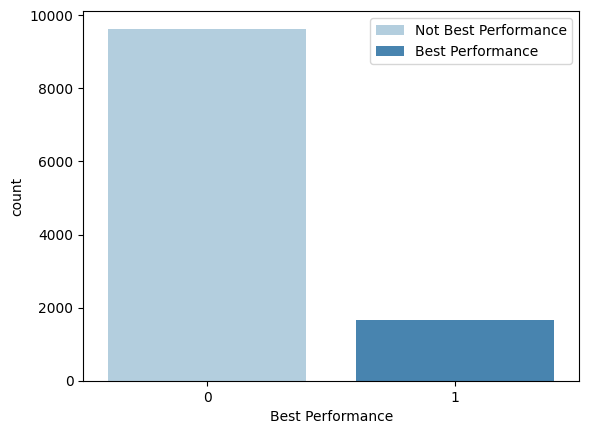

In [20]:
# Check class balanced
sns.countplot(train, x='Best Performance', hue='Best Performance', palette='Blues')

plt.legend(['Not Best Performance', 'Best Performance'])

#### SMOTE
Synthetic Minority Oversampling Technique merupakan teknik oversampling data dengan melakukan sintetis data pada kelas minoritas. <br>
Berdasarkan visualisasi diatas dapat terlihat bahwa best performance sebagai kelas minoritas.

In [21]:
oversampling = SMOTE()
X_train_balance, y_train_balance = oversampling.fit_resample(X=train[col_x], y=train['Best Performance'])

train = pd.DataFrame(columns=col_x, data=X_train_balance)

train['Best Performance'] = y_train_balance

train.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),...,assign_of_otherposition,annual leave,sick_leaves,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3,Best Performance
0,3,8.00,6,8.00,0.50,1,1,1,57,1,...,0,8,0,68.850000,72.53,0.0,2.0,2.0,0.0,0
1,2,5.17,4,2.00,1.25,1,1,1,42,1,...,9,3,0,94.810000,101.13,3.0,2.0,2.0,0.0,0
2,2,1.83,3,1.83,1.50,1,1,1,41,1,...,0,6,0,72.820000,71.30,0.0,3.0,3.0,1.0,0
3,2,7.92,4,4.00,0.17,1,1,1,37,1,...,0,3,0,86.890000,90.09,2.0,2.0,2.0,1.0,0
4,2,1.75,3,1.75,1.33,2,1,1,35,0,...,0,0,2,66.816667,70.43,0.0,2.0,2.0,0.0,1


setelah proses oversampling dapat terlihat bahwa label kelas seimbang dan secara ukuran data bertambah dari 11280 ke 19262 baris data

In [22]:
train.shape

(19262, 30)

In [23]:
train['Best Performance'].value_counts()

Best Performance
0    9631
1    9631
Name: count, dtype: int64

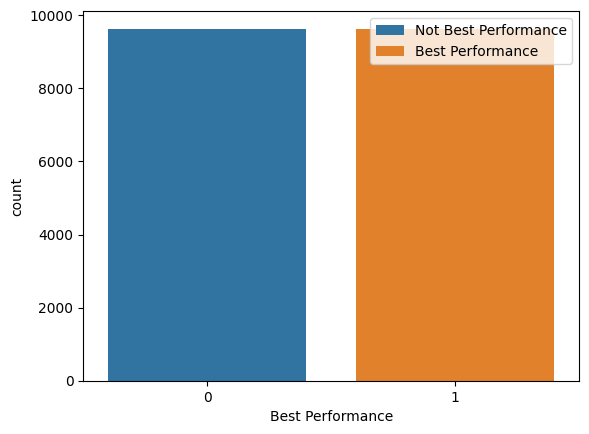

In [24]:
# Check class balanced
sns.countplot(train, x='Best Performance', hue='Best Performance')

plt.legend(['Not Best Performance', 'Best Performance'])

In [25]:
train_df.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,Employee_status,gender,age,marital_status_maried(Y/N),...,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Avg_achievement_%,Last_achievement_%,Achievement_above_100%_during3quartal,achievement_target_1,achievement_target_2,achievement_target_3
0,3.786173,3.639489,4.129932,6.368231,-0.820122,-0.689543,0.0,0.0,4.895147,0.415693,...,1.937877,-0.462426,1.652975,-0.363473,0.086937,0.015017,-0.615098,-0.139834,-0.139834,-0.629729
1,-0.238331,1.861410,1.157962,0.092376,0.014683,-0.689543,0.0,0.0,1.549647,0.415693,...,1.937877,3.045418,-0.244676,-0.363473,1.244375,1.266278,2.091772,-0.139834,-0.139834,-0.629729
2,-0.238331,-0.237099,-0.328023,-0.085440,0.292951,-0.689543,0.0,0.0,1.326614,0.415693,...,3.039459,-0.462426,0.893915,-0.363473,0.263941,-0.038796,-0.615098,1.219932,1.219932,1.587986
3,-0.238331,3.589225,1.157962,2.184328,-1.187436,-0.689543,0.0,0.0,0.434480,0.415693,...,0.836294,-0.462426,-0.244676,-0.363473,0.891259,0.783274,1.189482,-0.139834,-0.139834,1.587986
4,-0.238331,-0.287363,-0.328023,-0.169118,0.103729,1.047016,0.0,0.0,-0.011587,-2.405619,...,0.836294,-0.462426,-1.383266,0.269581,-0.003720,-0.076859,-0.615098,-0.139834,-0.139834,-0.629729


In [26]:
def roc_auc_curve(clf, X, y):
    pred_proba = clf.predict_proba(X)[:,1]

    fpr, tpr, _ = roc_curve(y, pred_proba)

    return fpr, tpr

#### Fitur
Pada bagian ini, X adalah prediktor dan y adalah kelas label

In [27]:
X_train = train[col_x] 
y_train = train['Best Performance']

print(X_train.shape)

(19262, 29)


Bagi data menjadi x dan y training serta x dan y untuk testing. Komposisinya adalah training:testing yaitu 70:30

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=None)

print('Train feature:', X_train.shape)
print('Test feature:', X_test.shape)

Train feature: (13483, 29)
Test feature: (5779, 29)


#### Training Model
Model dibangun dengan menerapkan algoritma Random Forest, Light Gradient Boosting, dan Naive Bayes. Parameter yang digunakan secara default <br>
Untuk mendapatkan fitur yang paling berpengaruh dalam prediksi, digunakan Random Forest dan Light Gradient Boosting feature importance.

In [29]:
# Random Forest
clf_rf = RandomForestClassifier(random_state=0)

clf_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [30]:
# Light Gradient Boosting
clf_lgbm = LGBMClassifier(random_state=0)

clf_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6720, number of negative: 6763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3053
[LightGBM] [Info] Number of data points in the train set: 13483, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498405 -> initscore=-0.006378
[LightGBM] [Info] Start training from score -0.006378


LGBMClassifier(random_state=0)

In [31]:
# Naive Bayes
clf_nb = GaussianNB()

clf_nb.fit(X_train, y_train)

GaussianNB()

#### Prediksi Testing (Random Forest)

In [32]:
# Melakukan prediksi berdasarkan probabilitas
y_pred_rf = clf_rf.predict_proba(X_test)[:,1]

In [33]:
score = roc_auc_score(y_test, y_pred_rf)

# Lakukan cross validation sebanyak 10 kali
mean_score = cross_val_score(clf_rf, X_test, y_test, cv=10, scoring='roc_auc')

# Nilai rata-rata auc score
print('Mean ROC-AUC score Random Forest (RF):', np.mean(mean_score))

Mean ROC-AUC score Random Forest (RF): 0.9258642011704354


In [34]:
# Perhitungan threshold untuk memprediksi label
fpr_rf, tpr_rf, threshold = roc_curve(y_test, y_pred_rf)

J = tpr_rf - fpr_rf 
ix = np.argmax(J)

best_threshold_rf = threshold[ix]

print('Best threshold:', best_threshold_rf)

Best threshold: 0.48


In [35]:
y_pred_rf[y_pred_rf >= best_threshold_rf] = 1
y_pred_rf[y_pred_rf < best_threshold_rf] = 0

y_pred_rf

array([0., 1., 0., ..., 0., 0., 1.])

In [36]:
# Metrik evaluasi
print('Accuracy : {:.4f}'.format(accuracy_score(y_test, y_pred_rf)))
print('Precision : {:.4f}'.format(precision_score(y_test, y_pred_rf)))
print('Recall : {:.4f}'.format(recall_score(y_test, y_pred_rf)))
print('f1 score : {:.4f}'.format(f1_score(y_test, y_pred_rf)))

Accuracy : 0.9015
Precision : 0.9466
Recall : 0.8526
f1 score : 0.8972


<Axes: xlabel='score', ylabel='feature'>

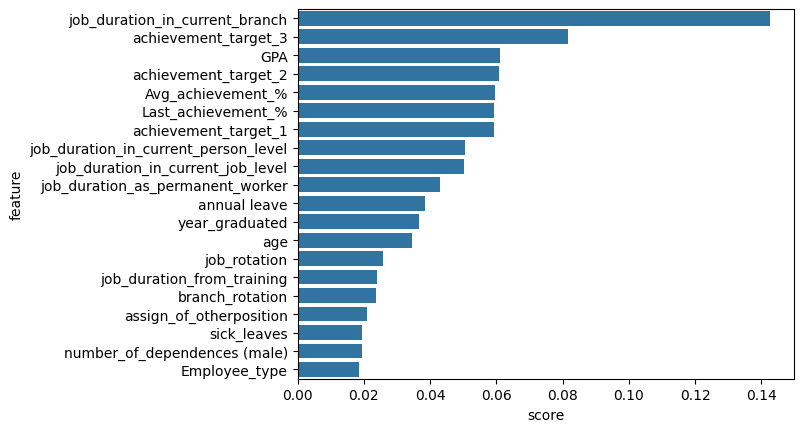

In [77]:
# Cek sebanyak 20 fitur yang mempunyai pengaruh paling tinggi terhadap model
columns = [x for x in train.columns if x != 'Best Performance']

feature_rf = pd.DataFrame(columns=['feature'], data=columns)

feature_rf['score'] = clf_rf.feature_importances_

feature_rf = feature_rf.sort_values(by='score', ascending=False).head(20)

sns.barplot(feature_rf, x='score', y='feature')

Size : (5779,)
Test 0: 2868
Test 1: 2911
Pred 0: 3157
Pred 1: 2622
[[2728  140]
 [ 429 2482]]
TN: 2728
FP: 140
FN: 429
TP: 2482


Text(50.722222222222214, 0.5, 'Actual')

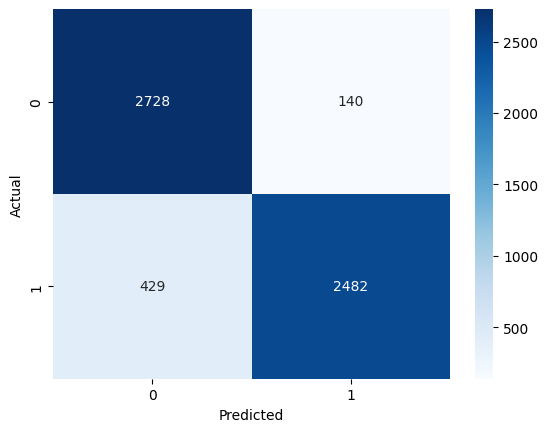

In [74]:
cm = confusion_matrix(y_test, y_pred_rf)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()

print('Size :', y_test.shape)
print(('============'))
print('Test 0:', sum(y_test == 0))
print('Test 1:', sum(y_test == 1))
print('Pred 0:', sum(y_pred_rf == 0))
print('Pred 1:', sum(y_pred_rf == 1))
print('============')
print(cm)
print(('============'))
print('TN:', tn)
print('FP:', fp)
print('FN:', fn)
print('TP:', tp)

ax = sns.heatmap(cm, annot=True, fmt='', cmap='Blues')

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

#### Prediksi Testing (Light Gradient Boosting)

In [39]:
# Melakukan prediksi berdasarkan probabilitas
y_pred_lgbm = clf_lgbm.predict_proba(X_test)[:,1]

In [40]:
score = roc_auc_score(y_test, y_pred_lgbm)

# Lakukan cross validation sebanyak 10 kali
mean_score = cross_val_score(clf_rf, X_test, y_test, cv=10, scoring='roc_auc')

# Nilai rata-rata auc score
print('Mean ROC-AUC score Light Gradient Boosting (LGBM):', np.mean(mean_score))

Mean ROC-AUC score Light Gradient Boosting (LGBM): 0.9258642011704354


In [41]:
# Perhitungan threshold untuk memprediksi label
fpr_lgbm, tpr_lgbm, threshold = roc_curve(y_test, y_pred_lgbm)

J = tpr_lgbm - fpr_lgbm 
ix = np.argmax(J)

best_threshold_lgbm = threshold[ix]

print('Best threshold:', best_threshold_lgbm)

Best threshold: 0.5033162878482323


In [42]:
y_pred_lgbm[y_pred_lgbm >= best_threshold_lgbm] = 1
y_pred_lgbm[y_pred_lgbm < best_threshold_lgbm] = 0

y_pred_lgbm

array([0., 1., 0., ..., 0., 0., 1.])

In [43]:
# Metrik evaluasi
print('Accuracy : {:.4f}'.format(accuracy_score(y_test, y_pred_lgbm)))
print('Precision : {:.4f}'.format(precision_score(y_test, y_pred_lgbm)))
print('Recall : {:.4f}'.format(recall_score(y_test, y_pred_lgbm)))
print('f1 score : {:.4f}'.format(f1_score(y_test, y_pred_lgbm)))

Accuracy : 0.9017
Precision : 0.9799
Recall : 0.8217
f1 score : 0.8939


<Axes: xlabel='score', ylabel='feature'>

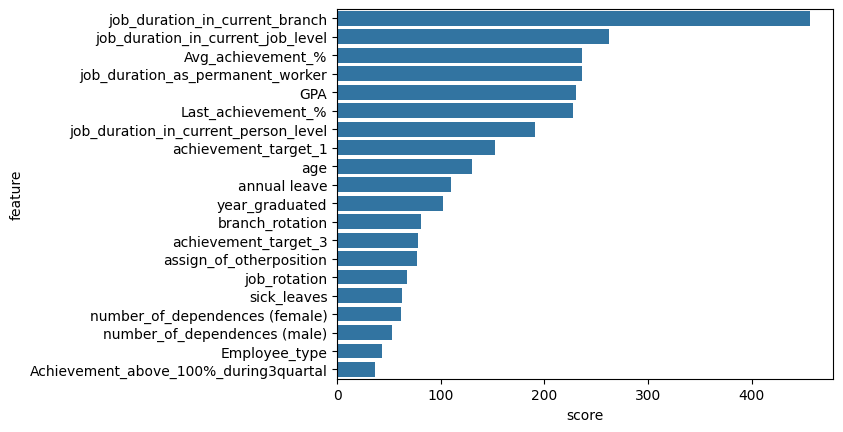

In [78]:
# Cek sebanyak 20 fitur yang mempunyai pengaruh paling tinggi terhadap model
columns = [x for x in train.columns if x != 'Best Performance']

feature_lgbm = pd.DataFrame(columns=['feature'], data=columns)

feature_lgbm['score'] = clf_lgbm.feature_importances_

feature_lgbm = feature_lgbm.sort_values(by='score', ascending=False).head(20)

sns.barplot(feature_lgbm, x='score', y='feature')

Size : (5779,)
Test 0: 2868
Test 1: 2911
Pred 0: 3338
Pred 1: 2441
[[2819   49]
 [ 519 2392]]
TN: 2819
FP: 49
FN: 519
TP: 2392


Text(50.722222222222214, 0.5, 'Actual')

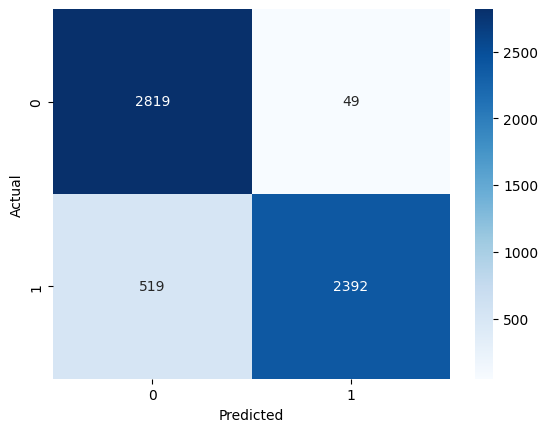

In [75]:
cm = confusion_matrix(y_test, y_pred_lgbm)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lgbm).ravel()

print('Size :', y_test.shape)
print(('============'))
print('Test 0:', sum(y_test == 0))
print('Test 1:', sum(y_test == 1))
print('Pred 0:', sum(y_pred_lgbm == 0))
print('Pred 1:', sum(y_pred_lgbm == 1))
print('============')
print(cm)
print(('============'))
print('TN:', tn)
print('FP:', fp)
print('FN:', fn)
print('TP:', tp)

ax = sns.heatmap(cm, annot=True, fmt='', cmap='Blues')

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

#### Prediksi Testing (Naive Bayes)

In [46]:
# Melakukan prediksi berdasarkan probabilitas
y_pred_nb = clf_nb.predict_proba(X_test)[:,1]

In [47]:
score = roc_auc_score(y_test, y_pred_nb)

# Lakukan cross validation sebanyak 10 kali
mean_score = cross_val_score(clf_nb, X_test, y_test, cv=10, scoring='roc_auc')

# Nilai rata-rata auc score
print('Mean ROC-AUC score K-Nearest Neighbor (KNN):', np.mean(mean_score))

Mean ROC-AUC score K-Nearest Neighbor (KNN): 0.6763866349142216


In [48]:
# Perhitungan threshold untuk memprediksi label
fpr_nb, tpr_nb, threshold = roc_curve(y_test, y_pred_nb)

J = tpr_nb - fpr_nb
ix = np.argmax(J)

best_threshold_nb = threshold[ix]

print('Best threshold:', best_threshold_nb)

Best threshold: 0.6738756670094529


In [49]:
y_pred_nb[y_pred_nb >= best_threshold_nb] = 1
y_pred_nb[y_pred_nb < best_threshold_nb] = 0

y_pred_nb

array([0., 0., 0., ..., 0., 0., 1.])

In [50]:
# Metrik evaluasi
print('Accuracy : {:.4f}'.format(accuracy_score(y_test, y_pred_nb)))
print('Precision : {:.4f}'.format(precision_score(y_test, y_pred_nb)))
print('Recall : {:.4f}'.format(recall_score(y_test, y_pred_nb)))
print('f1 score : {:.4f}'.format(f1_score(y_test, y_pred_nb)))

Accuracy : 0.6636
Precision : 0.6897
Recall : 0.6039
f1 score : 0.6440


Size : (5779,)
Test 0: 2868
Test 1: 2911
Pred 0: 3230
Pred 1: 2549
[[2077  791]
 [1153 1758]]
TN: 2077
FP: 791
FN: 1153
TP: 1758


Text(50.722222222222214, 0.5, 'Actual')

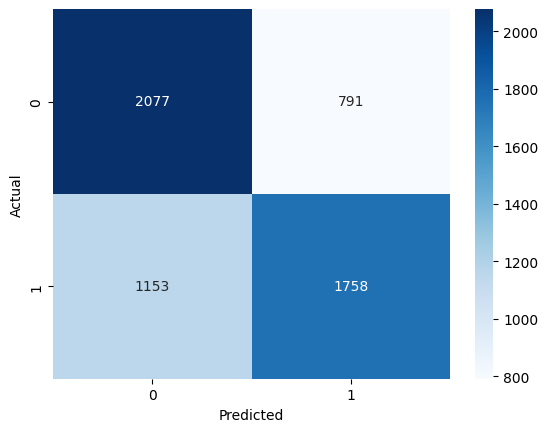

In [76]:
cm = confusion_matrix(y_test, y_pred_nb)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_nb).ravel()

print('Size :', y_test.shape)
print(('============'))
print('Test 0:', sum(y_test == 0))
print('Test 1:', sum(y_test == 1))
print('Pred 0:', sum(y_pred_nb == 0))
print('Pred 1:', sum(y_pred_nb == 1))
print('============')
print(cm)
print(('============'))
print('TN:', tn)
print('FP:', fp)
print('FN:', fn)
print('TP:', tp)

ax = sns.heatmap(cm, annot=True, fmt='', cmap='Blues')

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

#### Future Works 
Setelah melihat isi dari notebook, nantinya dapat terlihat bahwa model Naive Bayes memiliki skor evaluasi yang rendah. <br> 
Bagaimana jika melalukan pencarian terhadap parameter optimal ? Bagaimana apabila dengan metode k-best dipilih fitur yang terbaik untuk membentuk model ? <br>
Bagaimana dengan algoritma klasifikasi supervised lainnya seperti KNN, SVM, logistic regression dll ? <br>